### [1.6 Homework](https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/01-intro/homework.md)

In [1]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

## Q1 Downloading the data. Read the data for January. How many records are there?

In [2]:
# !wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet
# !wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet

In [3]:
df = pd.read_parquet('fhv_tripdata_2021-01.parquet')

In [4]:
len(df)

1154112

# Q2. Computing duration. What's the average trip duration in January?

**Warning**
```Timedelta('1 days 00:12:00').dt.seconds == 12.0``` 

:facepalm:
check row 581

In [5]:
df['duration'] = (df['dropOff_datetime'] - df['pickup_datetime'])

In [6]:
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [7]:
df['duration'].mean()

19.167224093791006

# Data preparation. 
Check the distribution of the duration variable. There are some outliers.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?



In [8]:
df['duration'].describe()

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

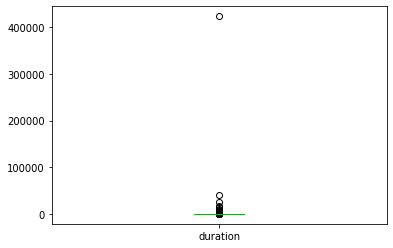

In [9]:
df['duration'].plot(kind='box');

In [10]:
len(df) - len(df.query('duration >= 1 and duration <= 60'))

44286

# Q3. Missing values. What's the fractions of missing values for the pickup location ID? Replace them with "-1".

In [11]:
df = df.query('duration >= 1 and duration <= 60').copy()

In [12]:
df['PUlocationID'].isna().value_counts(normalize = True)

True     0.835273
False    0.164727
Name: PUlocationID, dtype: float64

In [13]:
df['PUlocationID'] = df['PUlocationID'].mask(df['PUlocationID'].isna(), -1)

# Q4. One-hot encoding. 
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries
- Fit a dictionary vectorizer
- Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns).

In [14]:
# cols

categorical = ['PUlocationID', 'DOlocationID']
numerical = ['duration']

df[categorical] = df[categorical].astype(str)

In [15]:
train_dicts = df[categorical].to_dict(orient='records')

In [16]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [17]:
X_train.shape # 525 categorical + 1 numerical

(1109826, 525)

# Q5. Training a model.
Now let's use the feature matrix from the previous step to train a model.

- Train a plain linear regression model with default parameters
- Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [18]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.528519107212283

/home/carlos/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/carlos/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


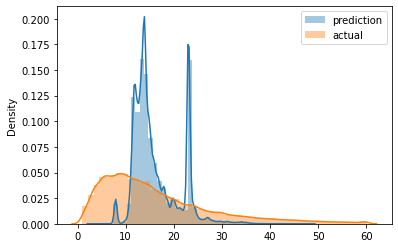

In [19]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend();

# Q6. Evaluating the model.
Now let's apply this model to the validation dataset (Feb 2021).

- What's the RMSE on validation?

In [20]:
def read_data(file):
    df = pd.read_parquet(file)
    df['duration'] = (df['dropOff_datetime'] - df['pickup_datetime'])
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df.query('duration >= 1 and duration <= 60').copy()
    df['PUlocationID'] = df['PUlocationID'].mask(df['PUlocationID'].isna(), -1)
    
    categorical = ['PUlocationID', 'DOlocationID']
    numerical = ['duration']

    df[categorical] = df[categorical].astype(str)
    
    return df[categorical + numerical]

In [21]:
df_val = read_data('fhv_tripdata_2021-02.parquet')

In [22]:
# ops! There is one new categorical value in february

In [23]:
def check_categories(column: str):
    df_uniq = set(df[column])
    df_val_uniq = set(df_val[column])

    for i in df_val_uniq:
        if i not in df_uniq:
            print (i)

In [24]:
check_categories('PUlocationID')

In [25]:
check_categories('DOlocationID')

110.0


In [26]:
# fix the problem
df_val['DOlocationID'].replace('110.0', 'nan', inplace = True)

In [27]:
# continuing with the prediction

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.fit_transform(val_dicts)
y_val_predict = lr.predict(X_val)

y_val = df_val['duration']

In [28]:
mean_squared_error(y_val, y_val_predict, squared=False)

11.014291750637167

/home/carlos/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/carlos/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


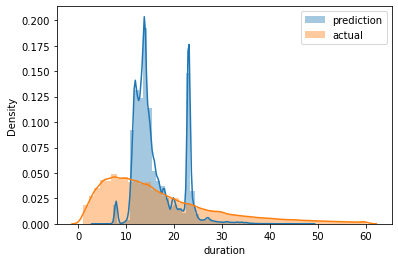

In [29]:
sns.distplot(y_val_predict, label='prediction')
sns.distplot(y_val, label='actual')

plt.legend();